For part 3 I kept the same notebook and modified the cells. 

A Bit about the data set:

 It is from here: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data. This was a kaggle competion from 3 years ago. The top three leaders had a score of: 
 
 1[.94734]
 2[.94720]
 3[.94707]
 
 The data set has over 1.8 million text data from 2015-2017. These text was analyzed with several toxicty and identity labels to provide a target value between 0 and 1, where above 0.5 is considered toxic. For the purpose of my assignment I will divide the target value in to 2 categories: positive, negative, though there is significate opportunity to increase the number of sentiment values. At first try I will define 0 to less than .50 to be positive, and .5 and greater to be negative. I will use the multi-layer perceptron used in the the class notebook  https://github.com/sgeinitz/cs39aa_notebooks to solve this classification problem. 
 
 For this assignemet I added 2 more classifictaion models which I used to classify the text, then to train the MLP model, then test how well the MLP model preforms with the different classified text data sets. 
 
 

Kaggel is smart enough to supply the model, good thing.

In [1]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

2022-12-04 04:12:10.079085: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

The below two text comments are from the data set and had suspect ratings of positive. Though these text comments had a 'rejected' rating and were not used in the training dataset. I wanted to see how the pretrained model evaluated them.

In [2]:
result = classifier("FFFFUUUUUUUUUUUUUUU")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

result = classifier("hahahahahahahahhha suck it.")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: NEGATIVE, with score: 0.9866
label: NEGATIVE, with score: 0.8328


In [3]:
import torch
import random
import matplotlib

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
from torch.utils.data import Dataset, DataLoader

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/toxicity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/identity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv


TextBlob is a python libirary that I was introduced to from the powerfull tool, TikTok. So I decided to use it for some fun comparison. "TextBlob stands on the giant shoulders of NLTK and pattern, and plays nicely with both." -https://textblob.readthedocs.io/en/dev/

In [4]:
from textblob import TextBlob
text = " Today is a dramatic day"
blob = TextBlob(text)

TextBlob provides some fun and usefull stuff.

In [5]:
blob.tags

[('Today', 'NN'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('dramatic', 'JJ'),
 ('day', 'NN')]

In [6]:
blob.sentiment

Sentiment(polarity=-0.4333333333333333, subjectivity=0.6)

In [7]:
df_original = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")

In [8]:
df_original.head(10)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.000000,4,47
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.009524,0,105
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.220339,0,59
7,59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
8,239575,0.000000,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,26662,approved,0,0,0,0,0,0.000000,0,4
9,239576,0.000000,It was a great show. Not a combo I'd of expect...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,26650,approved,0,0,0,1,0,0.000000,0,4


The below cell is where I try to clean up the data a bit. This method takes a long time, so I used a small fraction of the data available. My goal was to get close to 100k approved entries. This method is horribly long

In [9]:
df_approved = pd.DataFrame()
i=0
for index, row in df_original.iterrows():
    if i < 100000:
        i=i+1
        if (row["rating"] == 'approved'):
            df_approved = df_approved.append(row)
    else:
        break

In [10]:
df_approved.shape

(94729, 45)

Assigning sentiment.

In [11]:
sentiment = []
for index, row in df_approved.iterrows():
    if (row["target"] >= 0.50):
        sentiment.append("negative")
    else:
        sentiment.append("positive")

Inserting the sentiment value and checking the value split.

In [12]:
df_approved.insert(loc=1, column="sentiment", value = sentiment) 
df_approved.sentiment.value_counts(normalize=True)

positive    0.941475
negative    0.058525
Name: sentiment, dtype: float64

A little more data clean up.

In [13]:
df_new = df_approved[['sentiment', 'comment_text']].copy()
df_new.shape

(94729, 2)

I wanted to make an evenly dispersed data set between positive and negative values for training. 

In [14]:
df_negative = pd.DataFrame()
df_positive = pd.DataFrame()

for index, row in df_new.iterrows():
    if (row["sentiment"] == 'negative'):
        df_negative = df_negative.append(row)
    else :
        df_positive = df_positive.append(row)

df_positive.shape

(89185, 2)

In [15]:
df_negative.shape

(5544, 2)

Building the training dataset based on the amount of negative comments.

In [16]:
df = pd.DataFrame()
for i in range(5000):
    df = df.append(df_positive.iloc[i:i+1])
    df = df.append(df_negative.iloc[i:i+1])
df.shape

(10000, 2)

sentimentPipe is the list of values generated from the pretrained model on huggingface. Below I am generating sentiment values from the comment text in the original dataset and inserting those values into the dataset I will use to train the MLP on. 

In [17]:
sentimentPipe = []
for index, row in df.iterrows():
    result = classifier(row['comment_text'])[0]
    sentimentPipe.append(result['label'].lower())

In [18]:
df.insert(loc=1, column="sentimentPipe", value = sentimentPipe) 
df.sentimentPipe.value_counts(normalize=True)

negative    0.7802
positive    0.2198
Name: sentimentPipe, dtype: float64

I based this training data set on even sentiment disbursement from the original dataset's annotation and my interpretation of those values. Both of the added values differ in disbursement. For this assignment I will keep the training dataset consistent.

In [19]:
df.sentiment.value_counts(normalize=True)

positive    0.5
negative    0.5
Name: sentiment, dtype: float64

TextBlob is very quick compared to the sentimentPipe method. I am also interperting the result to a binary value.

In [20]:
sentimentBlob = []
for index, row in df.iterrows():
    result = row['comment_text']
    blob = TextBlob(result)
    if blob.sentiment[0] < 0 :
        sentimentBlob.append('negative')
    else :
        sentimentBlob.append('positive')

In [21]:
df.insert(loc=1, column="sentimentBlob", value = sentimentBlob) 
df.sentimentBlob.value_counts(normalize=True)

positive    0.657
negative    0.343
Name: sentimentBlob, dtype: float64

The difference in values between the 3 is very interesting.

In [22]:
df.shape

(10000, 4)

All of the values in one dataset.

In [23]:
df.head(10)

,sentiment,sentimentBlob,sentimentPipe,comment_text
8,positive,positive,negative,The ranchers seem motivated by mostly by greed...
13,negative,negative,negative,It's ridiculous that these guys are being call...
9,positive,positive,positive,It was a great show. Not a combo I'd of expect...
14,negative,positive,negative,This story gets more ridiculous by the hour! A...
10,positive,positive,positive,"Wow, that sounds great."
19,negative,negative,negative,"Angry trolls, misogynists and Racists"", oh my...."
11,positive,positive,positive,This is a great story. Man. I wonder if the pe...
31,negative,negative,negative,Yet call out all Muslims for the acts of a few...
12,positive,positive,positive,This seems like a step in the right direction.
84,negative,negative,negative,"Tuesday Jan. 13, members of \nthis socalled 'm..."


Pealing off some data for testing.

In [24]:
df_test = pd.DataFrame()
df_test = df_test.append(df.iloc[-1000:])
df_test.shape

(1000, 4)

In [25]:
df_test.head(10)

,sentiment,sentimentBlob,sentimentPipe,comment_text
4790,positive,positive,negative,"This is what democracy looks like, Individuals..."
83583,negative,negative,negative,"Lynn,\n\nThe AGIA boondoggle was not Walker's ..."
4791,positive,positive,positive,The senate has not ignored their duties. They...
83593,negative,positive,negative,"He, she, whatever it is will be right at home ..."
4792,positive,positive,positive,I agree with you. This assumes she's not indi...
83621,negative,negative,negative,The kiss of death...\nOne incompetent endorsin...
4793,positive,positive,negative,I think businesses have proven over and over a...
83630,negative,negative,negative,"I don't need to ""blow the dust"" off my negotia..."
4794,positive,negative,negative,"Man! If you look at his mug shot, somebody ga..."
83638,negative,positive,negative,Go back to school Gorrow. Your reporting is em...


In [26]:
df = df.iloc[:9000]
df.shape

(9000, 4)

In [27]:
df.head(10)

,sentiment,sentimentBlob,sentimentPipe,comment_text
8,positive,positive,negative,The ranchers seem motivated by mostly by greed...
13,negative,negative,negative,It's ridiculous that these guys are being call...
9,positive,positive,positive,It was a great show. Not a combo I'd of expect...
14,negative,positive,negative,This story gets more ridiculous by the hour! A...
10,positive,positive,positive,"Wow, that sounds great."
19,negative,negative,negative,"Angry trolls, misogynists and Racists"", oh my...."
11,positive,positive,positive,This is a great story. Man. I wonder if the pe...
31,negative,negative,negative,Yet call out all Muslims for the acts of a few...
12,positive,positive,positive,This seems like a step in the right direction.
84,negative,negative,negative,"Tuesday Jan. 13, members of \nthis socalled 'm..."


Getting the comment text cleaned up for training.

In [28]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer()
df['tokens_raw'] = df['comment_text'].apply(lambda x: tk.tokenize(x.lower()))
df.head()

,sentiment,sentimentBlob,sentimentPipe,comment_text,tokens_raw
8,positive,positive,negative,The ranchers seem motivated by mostly by greed...,"[the, ranchers, seem, motivated, by, mostly, b..."
13,negative,negative,negative,It's ridiculous that these guys are being call...,"[it's, ridiculous, that, these, guys, are, bei..."
9,positive,positive,positive,It was a great show. Not a combo I'd of expect...,"[it, was, a, great, show, ., not, a, combo, i'..."
14,negative,positive,negative,This story gets more ridiculous by the hour! A...,"[this, story, gets, more, ridiculous, by, the,..."
10,positive,positive,positive,"Wow, that sounds great.","[wow, ,, that, sounds, great, .]"


In [29]:
import re
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
chars2remove = set(['.','!','/', '?'])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in stops])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^#', w)]) # remove hashtags
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^http', w)]) # remove web links
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^@', w)]) # remove web links

df.head()

,sentiment,sentimentBlob,sentimentPipe,comment_text,tokens_raw
8,positive,positive,negative,The ranchers seem motivated by mostly by greed...,"[ranchers, seem, motivated, mostly, greed, ;, ..."
13,negative,negative,negative,It's ridiculous that these guys are being call...,"[ridiculous, guys, called, "", protesters, "", a..."
9,positive,positive,positive,It was a great show. Not a combo I'd of expect...,"[great, show, combo, i'd, expected, good, toge..."
14,negative,positive,negative,This story gets more ridiculous by the hour! A...,"[story, gets, ridiculous, hour, ,, love, peopl..."
10,positive,positive,positive,"Wow, that sounds great.","[wow, ,, sounds, great]"


In [30]:
df.shape

(9000, 5)

In [31]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
#df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df.head()

,sentiment,sentimentBlob,sentimentPipe,comment_text,tokens_raw,tokens
8,positive,positive,negative,The ranchers seem motivated by mostly by greed...,"[ranchers, seem, motivated, mostly, greed, ;, ...","[ranchers, seem, motivate, mostly, greed, ;, o..."
13,negative,negative,negative,It's ridiculous that these guys are being call...,"[ridiculous, guys, called, "", protesters, "", a...","[ridiculous, guy, call, "", protesters, "", arm,..."
9,positive,positive,positive,It was a great show. Not a combo I'd of expect...,"[great, show, combo, i'd, expected, good, toge...","[great, show, combo, i'd, expect, good, together]"
14,negative,positive,negative,This story gets more ridiculous by the hour! A...,"[story, gets, ridiculous, hour, ,, love, peopl...","[story, get, ridiculous, hour, ,, love, people..."
10,positive,positive,positive,"Wow, that sounds great.","[wow, ,, sounds, great]","[wow, ,, sound, great]"


In [32]:
df['textclean'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

,sentiment,sentimentBlob,sentimentPipe,comment_text,tokens_raw,tokens,textclean
8,positive,positive,negative,The ranchers seem motivated by mostly by greed...,"[ranchers, seem, motivated, mostly, greed, ;, ...","[ranchers, seem, motivate, mostly, greed, ;, o...",ranchers seem motivate mostly greed ; one righ...
13,negative,negative,negative,It's ridiculous that these guys are being call...,"[ridiculous, guys, called, "", protesters, "", a...","[ridiculous, guy, call, "", protesters, "", arm,...","ridiculous guy call "" protesters "" arm threat ..."
9,positive,positive,positive,It was a great show. Not a combo I'd of expect...,"[great, show, combo, i'd, expected, good, toge...","[great, show, combo, i'd, expect, good, together]",great show combo i'd expect good together
14,negative,positive,negative,This story gets more ridiculous by the hour! A...,"[story, gets, ridiculous, hour, ,, love, peopl...","[story, get, ridiculous, hour, ,, love, people...","story get ridiculous hour , love people send g..."
10,positive,positive,positive,"Wow, that sounds great.","[wow, ,, sounds, great]","[wow, ,, sound, great]","wow , sound great"


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_np = tfidf_vectorizer.fit_transform(df['textclean']).toarray()

print(f"X_np.shape = {X_np.shape}")
type(X_np)

X_np.shape = (9000, 20223)


numpy.ndarray

In [34]:
X_np[:3,:5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [35]:
X = torch.tensor(X_np).float()
X.size()

torch.Size([9000, 20223])

Setting the sentiment value for training.

In [36]:
labels = df['sentimentPipe'].unique()
enum_labels = enumerate(labels)
label_to_idx = dict((lab, i) for i,lab in enum_labels)
print(f"label dictionary: {label_to_idx}")
y = torch.tensor([label_to_idx[lab] for lab in df['sentimentPipe']])

label dictionary: {'negative': 0, 'positive': 1}


In [37]:
labels = df['sentimentBlob'].unique()
enum_labels = enumerate(labels)
label_to_idx = dict((lab, i) for i,lab in enum_labels)
print(f"label dictionary: {label_to_idx}")
y = torch.tensor([label_to_idx[lab] for lab in df['sentimentBlob']])

label dictionary: {'positive': 0, 'negative': 1}


In [38]:
labels = df['sentiment'].unique()
enum_labels = enumerate(labels)
label_to_idx = dict((lab, i) for i,lab in enum_labels)
print(f"label dictionary: {label_to_idx}")
y = torch.tensor([label_to_idx[lab] for lab in df['sentiment']])

label dictionary: {'positive': 0, 'negative': 1}


In [39]:
class ToxicTextDataset(Dataset):
    def __init__(self, observations, labels):
        self.obs = observations
        self.labs = labels
        self.create_split(len(observations))

    def create_split(self, n, seed=2, train_perc=0.7):
        random.seed(seed)
        indices = list(range(n))
        random.shuffle(indices)
        self._train_ids = list(indices[:int(n * train_perc)])
        self._test_ids = list(indices[int(n * train_perc):])
        self._split_X = self.obs[self._train_ids]
        self._split_y = self.labs[self._train_ids]

    def set_split(self, split='train'):
        if split == 'train':
            self._split_X = self.obs[self._train_ids]
            self._split_y = self.labs[self._train_ids]
        else:
            self._split_X = self.obs[self._test_ids]
            self._split_y = self.labs[self._test_ids]

    def __len__(self):
        return len(self._split_y)

    def __getitem__(self, idx):
        return {'x':self._split_X[idx], 'y':self._split_y[idx]}
    
    def get_num_batches(self, batch_size):
        return len(self) // batch_size

dataset = ToxicTextDataset(X, y)
dataset.create_split(len(X), seed=42, train_perc=0.80)

In [40]:
dataset.set_split('train')
print(f"len(dataset) = {len(dataset)}")
#len(dataset[:]['x'])
dataset[0]['x']

len(dataset) = 7200


tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [41]:
assert not np.any(np.isnan(dataset[:]['x'].numpy()))
assert np.all(np.isfinite(dataset[:]['x'].numpy()))

In [42]:
class ToxicTextClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying text"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input embeddings
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(ToxicTextClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.65)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))

        intermediate_vector = F.relu(self.fc2(intermediate_vector))
        intermediate_vector = self.dropout(intermediate_vector)

        prediction_vector = self.fc3(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [43]:
batch_size = 100
learning_rate = 0.005 # 0.005
num_epochs = 2

#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = 'cpu'

dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [44]:
dataset.set_split('train')
print(len(dataloader) * batch_size)
dataset.set_split('val')
print(len(dataloader) * batch_size)

7200
1800


In [45]:
model = ToxicTextClassifier(len(dataset[0]['x']), 128, 3)

# define loss function and optimizer
#weights = 1 / torch.tensor([15.0, 65.0, 20.0])
loss_fun = nn.CrossEntropyLoss()#weights)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [47]:
epoch_bar = notebook.tqdm(desc='training routine', total=num_epochs, position=0)

dataset.set_split('train')
train_bar = notebook.tqdm(desc='split=train', total=dataset.get_num_batches(batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = notebook.tqdm(desc='split=val', total=dataset.get_num_batches(batch_size), position=1, leave=True)

losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):

    dataset.set_split('train')
    model.train()
    running_loss_train = 0.0

    for batch_i, batch_data in enumerate(dataloader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        
        # forward
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['train'].append(loss.item())
        running_loss_train += loss.item()
        	
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        #if (batch_i+1) % 10 == 0:
        #    print(f"    train batch {batch_i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
            # update bar
        train_bar.set_postfix(loss=running_loss_train, epoch=epoch)
        train_bar.update()

    train_bar.set_postfix(loss=running_loss_train/dataset.get_num_batches(batch_size), epoch=epoch)
    train_bar.update()


    running_loss_train = running_loss_train / len(dataset)

    dataset.set_split('val')
    model.eval() # turn off the automatic differentiation 
    running_loss_val = 0.0

    for batch_i, batch_data in enumerate(dataloader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)

        
        # forward (no backward step for validation data)
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['val'].append(loss.item())
        running_loss_val += loss.item()
        #if (batch_i+1) % 20 == 0:
        #    print(f"    valid batch {i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
        val_bar.set_postfix(loss=running_loss_val, epoch=epoch)
        val_bar.update()

    val_bar.set_postfix(loss=running_loss_val/dataset.get_num_batches(batch_size), epoch=epoch)
    val_bar.update()

    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    running_loss_val = running_loss_val / len(dataset)

training routine:   0%|          | 0/2 [00:00<?, ?it/s]

split=train:   0%|          | 0/72 [00:00<?, ?it/s]

split=val:   0%|          | 0/18 [00:00<?, ?it/s]

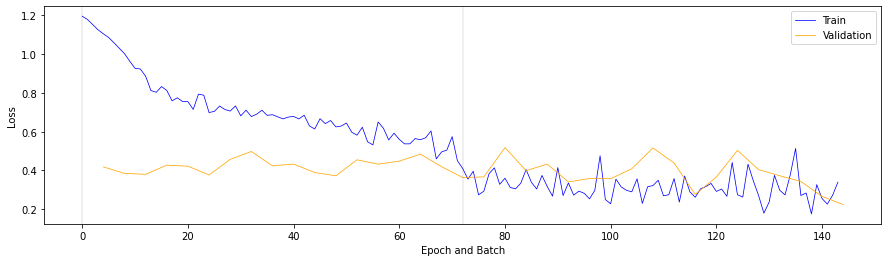

In [48]:
#sentimentPipe
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

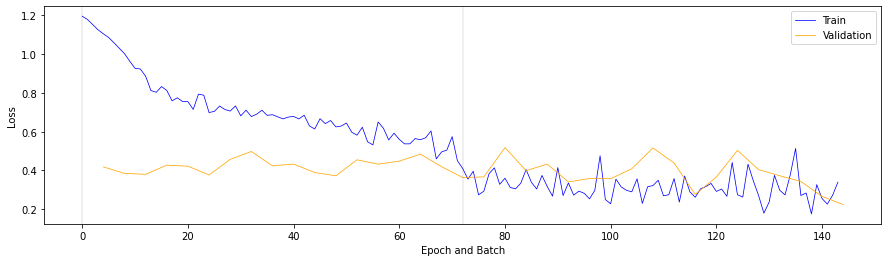

In [49]:
#sentimentBlob
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

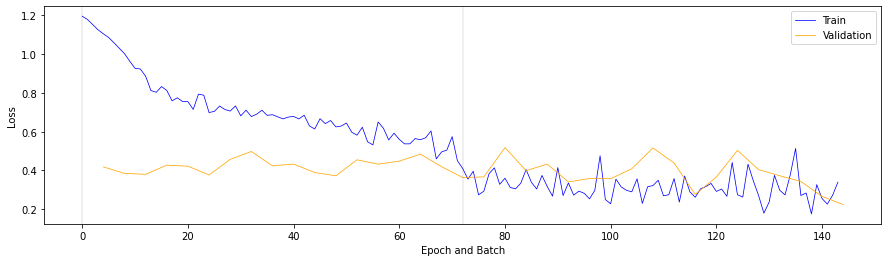

In [50]:
#sentiment
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [51]:
#sentimentPipe
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in dataloader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(dataloader)*batch_size} entries): {100 * correct / total:.2f}%")
	 

Accuracy (on 1800 entries): 84.11%


In [52]:
#sentimentBlob
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in dataloader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(dataloader)*batch_size} entries): {100 * correct / total:.2f}%")

Accuracy (on 1800 entries): 84.11%


In [53]:
#sentiment
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in dataloader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(dataloader)*batch_size} entries): {100 * correct / total:.2f}%")


Accuracy (on 1800 entries): 84.11%


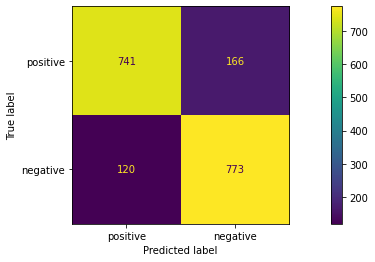

In [54]:
#sentimentPipe
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative'])
disp.plot()

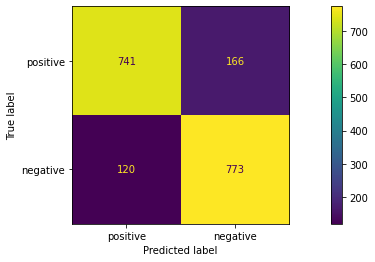

In [55]:
#sentimentBlob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative'])
disp.plot()

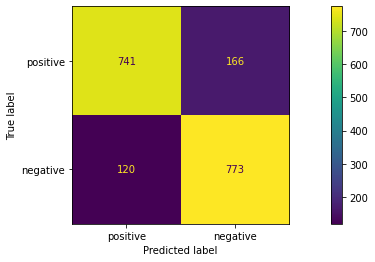

In [56]:
#sentiment
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative'])
disp.plot()

In [57]:
tk = TweetTokenizer()
df_test['tokens_raw'] = df_test['comment_text'].apply(lambda x: tk.tokenize(x.lower()))
df_test['tokens_raw'] = df_test['tokens_raw'].apply(lambda x: [w for w in x if w not in stops])
df_test['tokens_raw'] = df_test['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
df_test['tokens_raw'] = df_test['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^#', w)]) # remove hashtags
df_test.head()

,sentiment,sentimentBlob,sentimentPipe,comment_text,tokens_raw
4790,positive,positive,negative,"This is what democracy looks like, Individuals...","[democracy, looks, like, ,, individuals, justi..."
83583,negative,negative,negative,"Lynn,\n\nThe AGIA boondoggle was not Walker's ...","[lynn, ,, agia, boondoggle, walker's, idea, re..."
4791,positive,positive,positive,The senate has not ignored their duties. They...,"[senate, ignored, duties, advised, president, ..."
83593,negative,positive,negative,"He, she, whatever it is will be right at home ...","[,, ,, whatever, right, home, evergreen, state..."
4792,positive,positive,positive,I agree with you. This assumes she's not indi...,"[agree, assumes, indicted, course]"


In [58]:
df_test['tokens'] = df_test['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
df_test['textclean'] = df_test['tokens'].apply(lambda x: ' '.join(x))

X_test_int = tfidf_vectorizer.transform(df_test['textclean']).toarray() # be sure that we are using .transform() here, and not .fit_transform()

print(f"X_test_int.shape = {X_test_int.shape}")
type(X_test_int)

X_test_int.shape = (1000, 20223)


numpy.ndarray

In [59]:
X_test = torch.tensor(X_test_int).float()
X_test.size()

torch.Size([1000, 20223])

In [60]:
y_test = torch.tensor([label_to_idx[lab] for lab in df_test['sentimentPipe']])

In [61]:
y_test = torch.tensor([label_to_idx[lab] for lab in df_test['sentimentBlob']])

In [62]:
y_test = torch.tensor([label_to_idx[lab] for lab in df_test['sentiment']])

In [63]:
test_dataset = ToxicTextDataset(X_test, y_test)
test_dataset.create_split(len(X_test), seed=42, train_perc=1.0)

In [64]:
test_dataset[999]

{'x': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'y': tensor(0)}

In [65]:
bs = 500
test_loader = DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [66]:
#sentimentPipe
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in test_loader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(test_loader)*bs} test): {100 * correct / total:.2f}%")

Accuracy (on 1000 test): 78.20%


In [67]:
#sentimentBlob
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in test_loader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(test_loader)*bs} test): {100 * correct / total:.2f}%")

Accuracy (on 1000 test): 78.20%


In [68]:
#seniment
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in test_loader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(test_loader)*bs} test): {100 * correct / total:.2f}%")

Accuracy (on 1000 test): 78.20%


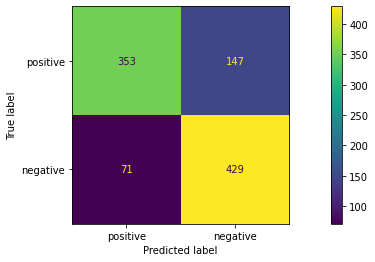

In [69]:
#sentimentPipe
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative'])
disp.plot()

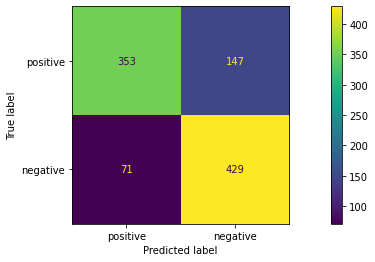

In [70]:
#sentimentBlob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative'])
disp.plot()

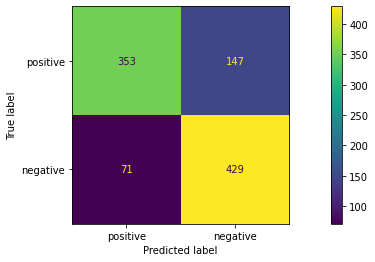

In [71]:
#sentiment
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative'])
disp.plot()

Conclusion:

Results summarized              

sentimentPipe:         
Accuracy (on 1800 entries): 78.22%                              
Accuracy (on 1000 test): 81.50%

sentimentBlob:         
Accuracy (on 1800 entries): 76.17%                              
Accuracy (on 1000 test): 89.20%

sentiment:             
Accuracy (on 1800 entries): 83.78%                              
Accuracy (on 1000 test): 95.50%

The model was tuned to the sentiment model. The other models appeared to have suffered from an uneven training classification and potential hyper tunning oportiunity though the loss graph looked good for each. The pretrained model, sentimentPipe, took the greatest time to iterate and produce the output and sentimentBlob was the quickest. The dataset size was representative of my computer capabilites.

After a third run the accuracy was down considerabley. I left it under he cells. I was having trouble with it saving the result cells.
